In [1]:
import sys
sys.path.append('..')
from d2l import torch as d2l
import torch
from torch import nn
import numpy as np
import math

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale = 0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.5821],
         [-0.9613]]),
 tensor([[ 1.0000e+00, -5.8214e-01,  1.6944e-01, -3.2879e-02,  4.7850e-03,
          -5.5711e-04,  5.4052e-05, -4.4951e-06,  3.2709e-07, -2.1157e-08,
           1.2316e-09, -6.5179e-11,  3.1619e-12, -1.4159e-13,  5.8875e-15,
          -2.2849e-16,  8.3132e-18, -2.8467e-19,  9.2065e-21, -2.8207e-22],
         [ 1.0000e+00, -9.6127e-01,  4.6202e-01, -1.4804e-01,  3.5577e-02,
          -6.8399e-03,  1.0958e-03, -1.5048e-04,  1.8082e-05, -1.9313e-06,
           1.8565e-07, -1.6224e-08,  1.2996e-09, -9.6098e-11,  6.5983e-12,
          -4.2285e-13,  2.5405e-14, -1.4365e-15,  7.6716e-17, -3.8813e-18]]),
 tensor([3.4010, 1.5188]))

In [4]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr = 0.01)
    animator = d2l.Animator(xlabel = 'epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim = [1e-3, 1e2], legend=["train", 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1)%20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print("weight:", net[0].weight.data.numpy())

weight: [[ 4.9775414  1.1972741 -3.3832924  5.578727 ]]


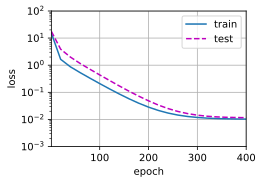

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.7847965 3.0141983]]


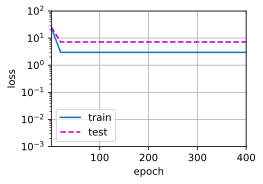

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.97032070e+00  1.23607469e+00 -3.29305124e+00  5.31899405e+00
  -4.34368789e-01  1.19877315e+00 -2.04076424e-01  6.52077869e-02
   3.29208486e-02  8.32535140e-03 -4.66376450e-03  4.86431494e-02
  -1.02735326e-01  9.85655785e-02  1.46360919e-01 -1.46133214e-01
   2.11173370e-01 -6.15631826e-02 -1.75692081e-01  1.20946527e-01]]


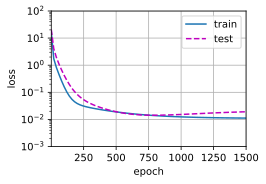

In [8]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)